In [52]:
import time

# AUT: Has a list of names and accesses for those names,
# and when a user is passed to it, it returns the corresponding actions a user can take after a delay of 5 seconds
class AUT:
    def __init__(self, userDict):
        self.userDict = userDict
    
    def isUserNameValid(self, username):
        time.sleep(3)
        return self.userDict.__contains__(username)
    
    def isActionAuthorized(self, username, action):
        time.sleep(3)
        return action in self.userDict[username]
    
    def getUserAuthorizedActions(self, accessorUsername, usernameToGet):
        time.sleep(3)
        if(self.isUserNameValid(accessorUsername) and self.isActionAuthorized(accessorUsername, "getUser")):
            return self.userDict[usernameToGet]
        return "Access Denied!"
    
    def addUser(self, accessorUsername, usernameToAdd, actionsToAdd):
        time.sleep(4)
        if(self.userDict.__contains__(accessorUsername) and "addUser" in self.userDict[accessorUsername]):
            self.userDict[usernameToAdd] = actionsToAdd
            return "Added User Successfully!"
        return "Access Denied!"

In [53]:
from graphviz import Digraph
# Process: Root gets activated by calling an activation task (defined and assigned to root runtime), root performs the task,
# saves the result in a 'context', calls the children's isActivationEligible by passing the context to the child,  
# every child that is eligible for activation does the same for its children. The path that is taken is relevant to the test data
# passed on the initial context. Once all test data is exhausted, all the un-visited nodes are shown (all nodes that haven't been visited
# after all test data is run, per test data obviously not all nodes will be visited because each test data will select a single flow
# to run) 

# Questions: Who should handle context - driver or node class. Used driver since context needs to be available across all nodes
# 2. How does the 'prior action results' object flow through the nodes? For now setting it on top node and having it flow through to children
# 3. How does the 'curr test data' object flow through the nodes? Same as above, but setting it on isActivationEligible

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((v, child))
                build(child)
    build(root)
    return nodes, edges

class Node:
    def __init__(self, description):
        self.description = description
        self.children = []
        self.testData = []
    
    def __repr__(self):
        return f"{self.description}"
    
    def setId(self, idd):
        self.id = idd
    
    def addChild(self, child):
        self.children.append(child)
    
    def display(self, globalVisited):
        dot = Digraph(format='svg', graph_attr={'rankdir': 'UD'}) # LR = left to right
        nodes, edges = trace(self)
        for n in nodes:
            uid = str(id(n))
            # for any value in the graph, create a rectangular ('record') node for it
            nodeColor = "green"
            if(n not in globalVisited):
                nodeColor = "red"
            dot.node(name = uid, label = "{ %s }" % (n), shape='record', color = nodeColor)

        for n1, n2 in edges:
            # connect n1 to the op node of n2
            dot.edge(str(id(n1)), str(id(n2)), n2.eligibilityDescription)

        return dot
    
    def setPriorActionResults(self, priorActionResults):
        self.priorActionResults = priorActionResults
    
    def setActivationEligibility(self, activationEligibilityFunction, eligibilityDescription):
        self.activationElibility=activationEligibilityFunction
        self.eligibilityDescription = eligibilityDescription
    
    def isActivationEligible(self, currTestData):
        isEligible = self.activationElibility(self.priorActionResults, currTestData)
        if(isEligible):
            self.setCurrTestData(currTestData)
        return isEligible
    
    def assignActivationTask(self, activationTaskFunction):
        self.activationTask=activationTaskFunction
        
    def setCurrTestData(self, currTestData):
        self.currTestData = currTestData
        if not currTestData in (self.testData):
            self.testData.append(currTestData)
    
    def activate(self, globalVisited):
        globalVisited.add(self)
        actionResult=self.activationTask(self.priorActionResults, self.currTestData)
        currActionResults = self.priorActionResults
        currActionResults[self.description]=actionResult
        print("action complete, actionResults: ", currActionResults)
        visited=set()
        
        for child in self.children:
            childActionResults = dict()
            for key, value in currActionResults.items():
                childActionResults[key] = value
            child.setPriorActionResults(childActionResults)
            if((child.isActivationEligible(self.currTestData)) & (child not in visited)):
                visited.add(child)
                child.activate(globalVisited)
                
    def copyNodeWithoutChildren(self):
        nodeWithoutChildren = Node(self.description)
        nodeWithoutChildren.assignActivationTask(self.activationTask)
        nodeWithoutChildren.setActivationEligibility(self.activationElibility, self.eligibilityDescription)
        nodeWithoutChildren.testData = self.testData
        return nodeWithoutChildren
    
    def getIndividualBranches(self):
        if(len(self.children) == 0):
            nodeMinusChildren = self.copyNodeWithoutChildren()
            res = [[]]
            res[0].append(nodeMinusChildren)
            return res
        
        res = []
        for child in self.children:
            childBranches = child.getIndividualBranches()
            for childBranch in childBranches:
                childBranch.append(self.copyNodeWithoutChildren())
                res.append(childBranch)
        return res

In [54]:
# const initialNodes = [
#   {
#     id: '1',
#     type: 'input',
#     data: { label: 'Input Node' },
#     position: { x: 250, y: 25 },
#   },

#   {
#     id: '2',
#     // you can also pass a React component as a label
#     data: { label: <div>Default Node</div> },
#     position: { x: 100, y: 125 },
#   },
#   {
#     id: '3',
#     type: 'output',
#     data: { label: 'Output Node' },
#     position: { x: 250, y: 250 },
#   },
# ];

# const initialEdges = [
#   { id: 'e1-2', source: '1', target: '2' },
#   { id: 'e2-3', source: '2', target: '3', animated: true },
#   { id: 'e1-3', source: '1', target: '3', animated: true },
#   { id: 'e0-1', source: '0', target: '1', animated: true },
# ];

# enterUserNode = Node("Enter User")
# def alwaysTrueActivation(priorActionResults, currTestData):
#     print("Enter User Node Activation!!")
#     return True
# enterUserNode.setActivationEligibility(alwaysTrueActivation, "Start of test!")
# def enterUserActivationTask(priorActionResults, currTestData):
#     return context['aut'].getUserAuthorizedActions(currTestData[0], currTestData[0]) # HOW TO Replace with test data ??
# enterUserNode.assignActivationTask(enterUserActivationTask)  

# invalidUsernameNode = Node("Invalid Username")
# def invalidUsernameActivationEligibility(priorActionResults, currTestData):
#     return priorActionResults['Enter User'] == "Access Denied!"
# invalidUsernameNode.setActivationEligibility(invalidUsernameActivationEligibility, "Access Denied")
# def invalidUserActivationTask(priorActionResults, currTestData):
#     print("Invalid User!")
# invalidUsernameNode.assignActivationTask(invalidUserActivationTask)

# enterUserNode.addChild(invalidUsernameNode)

def parseNodes(json):
    nodesIdMap = {}
    for nodeJson in json['nodes']:
        node = Node(nodeJson['data']['label'])
        node.setId(nodeJson['id'])
        
        activation_fn_name = "".join(ch for ch in node.description if ch.isalnum()) + "ActivationFunction"
        exec(f'def {activation_fn_name}(priorActionResults, currTestData):\n    ' + nodeJson['data']['activationEligibility'])
        node.setActivationEligibility(locals()[activation_fn_name], nodeJson['data']['activationEligibilityDescription'])
        
        task_fn_name = "".join(ch for ch in node.description if ch.isalnum()) + "ActivationTask"
        exec(f'def {task_fn_name}(priorActionResults, currTestData):\n    ' + nodeJson['data']['activationTask'])
        node.assignActivationTask(locals()[task_fn_name])
        nodesIdMap[nodeJson['id']] = node
    
    return nodesIdMap

def joinNodes(json, nodesIdMap):
    for edgeJson in json['edges']:
        nodesIdMap[edgeJson['source']].addChild(nodesIdMap[edgeJson['target']])
    
    
def createTreeFromJson(nodesJson, edgesJson):
    nodesIdMap = parseNodes(nodesJson)
    joinNodes(edgesJson, nodesIdMap)

    #Assumption - Lowest Id node is the root node - Fix give special un-editable description to root node
    return nodesIdMap[min(list(nodesIdMap.keys()))]
    

In [97]:
import json

context = {}
userDict = {"adminUser": ["addUser", "deleteUser", "editUser", "getUser"], "planeUser": ["getUser"]}
aut = AUT(userDict)
context['aut'] = aut

nodesJson =  """{ 
    "nodes": [
        {
            "id": "1",
            "type": "input",
            "data": {
                "label": "Enter User",
                "activationEligibility": "return True",
                "activationEligibilityDescription": "Start of Test!!",
                "activationTask": "return context['aut'].getUserAuthorizedActions(currTestData[0], currTestData[0])"
            },
            "position": {
                "x": 100,
                "y": 125
            }
        },
        {
            "id": "2",
            "type": "input",
            "data": {
                "label": "Invalid Username",
                "activationEligibility": "return priorActionResults['Enter User'] == \\"Access Denied!\\"",
                "activationEligibilityDescription": "Access Denied",
                "activationTask": "return \\"Invalid User!\\""
            },
            "position": {
                "x": 100,
                "y": 125
            }
        },
        {
            "id": "4",
            "type": "input",
            "data": {
                "label": "Action Unauthorized",
                "activationEligibility": "return priorActionResults['Enter User'] != 'Access Denied!' and currTestData[1] not in priorActionResults['Enter User']",
                "activationEligibilityDescription": "Action un-authorized",
                "activationTask": "return context['aut'].addUser(currTestData[0], 'ShouldReturnAccessDenied', 'dummyAction')"
            },
            "position": {
                "x": 100,
                "y": 125
            }
        },
        {
            "id": "3",
            "type": "input",
            "data": {
                "label": "Action Authorized",
                "activationEligibility": "return currTestData[1] in priorActionResults['Enter User']",
                "activationEligibilityDescription": "Access Denied",
                "activationTask": "return \\"Action is Authorized!\\""
            },
            "position": {
                "x": 100,
                "y": 125
            }
        }  
    ]
}"""
edgesJson =  """{"edges": [ { "id": "e1-2", "source": "1", "target": "2" },
                            { "id": "e1-3", "source": "1", "target": "3" },
                            { "id": "e1-4", "source": "1", "target": "4" }
                          ] }"""

# json.loads(nodesJson)
# json.loads(edgesJson)

globalVisited = set()
startNode = createTreeFromJson(json.loads(nodesJson), json.loads(edgesJson))
# startNode.display({})

testData = [["adminUser", "addUser"], ["nonExistentUser", "addUser"]]

for singleTestData in testData:
    startNode.setPriorActionResults({})
    startNode.isActivationEligible(singleTestData)
    startNode.activate(globalVisited)

action complete, actionResults:  {'Enter User': ['addUser', 'deleteUser', 'editUser', 'getUser']}
action complete, actionResults:  {'Enter User': ['addUser', 'deleteUser', 'editUser', 'getUser'], 'Action Authorized': 'Action is Authorized!'}
action complete, actionResults:  {'Enter User': 'Access Denied!'}
action complete, actionResults:  {'Enter User': 'Access Denied!', 'Invalid Username': 'Invalid User!'}


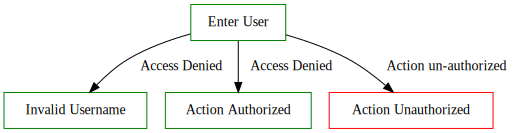

In [98]:
startNode.display(globalVisited)